# Análisis de las compras y contrataciones del Sector Público en Uruguay, en el período entre 2015 - 2018

# Importación de los datos

Se importan los datos de las siguientes planillas:

1.   '2015_awa_items.csv','2016_awa_items.csv','2017_awa_items.csv','2018_awa_items.csv' contiene información sobre los prodctos (items) y proveedores adjudicados en cada compra, en el año correspondiente.
2.   '2015_releases.csv','2016_releases.csv','2017_releases.csv','2018_releases.csv' contiene los datos algunos datos de la oferta, inclusive la Unidad de Compra (UC) que publica el llamado. 
3.    '2015_awa_suppliers.csv','2016_awa_suppliers.csv','2017_awa_suppliers.csv','2018_awa_suppliers.csv' contienen información descriptiva de los proveedores adjudicados.
4.   'Organismos.xls' contiene los códigos con los nombres de cada organismo y su unidad ejecutora.



In [1]:
from google.colab import files
uploaded = files.upload() # devuelve un diccionarioAl diccionario se le asignará el nombre del archivo como clave y los valores serán los datos que se han subido.

Saving 2015_awa_items.csv to 2015_awa_items.csv
Saving 2015_awa_suppliers.csv to 2015_awa_suppliers.csv
Saving 2015_releases.csv to 2015_releases.csv
Saving 2016_awa_items.csv to 2016_awa_items.csv
Saving 2016_awa_suppliers.csv to 2016_awa_suppliers.csv
Saving 2016_releases.csv to 2016_releases.csv
Saving 2017_awa_items.csv to 2017_awa_items.csv
Saving 2017_awa_suppliers.csv to 2017_awa_suppliers.csv
Saving 2017_releases.csv to 2017_releases.csv
Saving 2018_awa_items.csv to 2018_awa_items.csv
Saving 2018_awa_suppliers.csv to 2018_awa_suppliers.csv
Saving 2018_releases.csv to 2018_releases.csv
Saving Organismo.xlsx to Organismo.xlsx


In [2]:
!pip install cairocffi 
import cairocffi
!pip install python-igraph
import igraph as ig

import io
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import random
import statistics
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.5 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=f3c7890fbc83cc4fa70c24a3ef8c2f4ff5952c902e558d95baf9339b2f55971e
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 4.3 MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.9.11-py3-none-any.whl size=9074 sha256=5951cf9c353dafd592dfcf19971ec76b0d9db0a427b8b5d13e27f05ddcaf1a76
  Stored in directory: /root/.cache/pip/wheels/7d/e4/0c/0c83f70bd0b99ce8aea47a21f8e52502169e7dd17808d12f30
Successfully built python-igraph


In [3]:
paths = sorted(Path("").glob("*.csv"))
tab = {}
for pth in paths:
  name = pth.name.split(".")[0]
  g = pd.read_csv(io.BytesIO(uploaded[str(pth)]),decimal=',')
  tab[name]=g # diccionario con cada DF de elemento
  name = g # DF separadas para cada csv
  #print(name.shape,name.columns)

In [4]:
items=pd.DataFrame()
releases=pd.DataFrame()
suppliers=pd.DataFrame()

for k,df in tab.items():
  if k.endswith('items'):
    items=items.append(df)
  elif k.endswith('releases'):
    releases=releases.append(df,ignore_index=True)
  else :
    suppliers=suppliers.append(df,ignore_index=True)
#print(items.shape)
#print(releases.shape)
#print(suppliers.shape)

Se combinan las tablas de *item* y *releases* por medio de un "inner join" con el fin de incorporar a la tabla de *items*, los datos de la Unidad de Compra (UC) que adquiere cada uno.

In [5]:
it_rel=items.merge(releases,on='id')
#display(it_rel.head())
#it_rel.columns

Se crea una DataFrame llamada *data*, eliminando aquellas columnas que no aporta información para el análisis actual. Al mismo tiempo, se cambian los nombres a las columnas para que sean más ilustrativos.Además se agrega una columna con el valor total adquirido de cada bien.

In [6]:
data=it_rel.drop(['ocid_x','awards/0/items/0/unit/id','awards/0/items/0/description','ocid_y', 'language',
       'tag','tender/submissionMethodDetails','tender/procurementMethod',
       'tender/bidDate', 'tender/openingDate', 'tender/procuringEntity/id',
       'tender/procuringEntity/name', 'tender/status',
       'tender/tenderPeriod/endDate', 'tender/tenderPeriod/startDate',
       'tender/hasEnquiries', 'tender/enquiryPeriod/endDate',
       'tender/enquiryPeriod/startDate', 'tender/title',
       'tender/submissionMethod', 'initiationType', 'awards','parties','tender/description'],axis=1)
data.columns=['id_compra','id_proveedor','id_item','cantidad','cod_clasif_prod','clasif_prod','precio_unidad','moneda','unidad_medida','id_oferta','oferta_metodo','id_inc_ue','nombre_ue','fecha']
data.head()

id_compra    id_proveedor id_item cantidad  cod_clasif_prod  \
0  adjudicacion-503521  R/040003340014       1     55.0             7956   
1  adjudicacion-503521  R/040003340014       2     35.0             7956   
2  adjudicacion-503521  R/040003340014       3     50.0             7956   
3  adjudicacion-503521  R/040003340014       4      4.0             7956   
4  adjudicacion-503521  R/040003340014       5      3.0              737   

                           clasif_prod precio_unidad moneda unidad_medida  \
0  INTERRUPTOR TERMOMAGNETICO UNIPOLAR       77.8700    UYU        UNIDAD   
1  INTERRUPTOR TERMOMAGNETICO UNIPOLAR       77.8700    UYU        UNIDAD   
2  INTERRUPTOR TERMOMAGNETICO UNIPOLAR       77.8700    UYU        UNIDAD   
3  INTERRUPTOR TERMOMAGNETICO UNIPOLAR       77.8700    UYU        UNIDAD   
4  INTERRUPTOR TERMOMAGNETICO TRIPOLAR      123.7700    UYU        UNIDAD   

  id_oferta         oferta_metodo id_inc_ue  \
0    503521  Compra por Excepción      25-4   
1    503521  Compra por Excepción      25-4   
2    503521  Compra por Excepción      25-4   
3    503521  Compra por Excepción      25-4   
4    503521  Compra por Excepción      25-4   

                                  nombre_ue                 fecha  
0  Consejo de Educación Técnico-Profesional  2015-12-04T13:05:00Z  
1  Consejo de Educación Técnico-Profesional  2015-12-04T13:05:00Z  
2  Consejo de Educación Técnico-Profesional  2015-12-04T13:05:00Z  
3  Consejo de Educación Técnico-Profesional  2015-12-04T13:05:00Z  
4  Consejo de Educación Técnico-Profesional  2015-12-04T13:05:00Z

Dado que va a ser relevante estudiar la relación con los proveedores y los Incisos pero la información se presenta a nivel de Unidad Ejecutora, a continuación se utiliza la planilla auxiliar "Organismo" para identificar el Inciso al cual pertenece cada UE.

In [7]:
UC= pd.read_excel(io.BytesIO(uploaded['Organismo.xlsx']))
UC.head()

id_inc_ue  id_inc                   nombre_inc  id_ue  \
0       1-1       1            Poder Legislativo      1   
1       1-2       1            Poder Legislativo      2   
2       1-3       1            Poder Legislativo      3   
3       2-1       2  Presidencia de la República      1   
4      2-10       2  Presidencia de la República     10   

                                           nombre_ue  
0                                Cámara de Senadores  
1                           Cámara de Representantes  
2      Comisión Administrativa del Poder Legislativo  
3  Presidencia  de la República y Oficinas Depend...  
4                                             AGESIC

Se realiza un Inner Join de 'data' con 'inciso' por 'id_inc_ue'.

In [8]:
data_inc=data.merge(UC,on='id_inc_ue')
data_inc['nombre_ue']=data_inc['nombre_ue_y']
data_inc=data_inc.drop(['nombre_ue_x','nombre_ue_y'],axis=1)

#Se controla que no haya quedado ningún organismo comprador fuera del join
#dif=data.merge(UC,on='id_inc_ue',indicator=True,how='left')
#print(dif.groupby('_merge')['id_inc_ue'].count())
#only_data=dif[dif['_merge']=='left_only']
#len(only_data)
#only_data.groupby('id_inc_ue')['id_inc_ue'].count()

# Transformación de los Datos

Se realizan una serie de transformaciones a los datos con el fin de que el Tipo de Dato sea coherente, además de contar con las variables necesarias para el análisis. 

Se comienza transformando el tipo de dato de la columna 'fecha' a 'DataTime' para poder utilizar los métodos propios de este tipo de objeto. Luego, se incorpora una columna calculada con el año que facilitará el planteo del modelo.

Luego se analiza la existencia de Missing Values y se decide su tratamiento.

Por otro lado, se calcula la columna 'Val_Tot' que refleja el valor total de los ítems a nivel de cada compra como la multiplicación de la cantidad que se adquiere de cada ítem por el precio por unidad.

In [9]:
data_inc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614222 entries, 0 to 614221
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id_compra        614222 non-null  object
 1   id_proveedor     614222 non-null  object
 2   id_item          614222 non-null  object
 3   cantidad         614222 non-null  object
 4   cod_clasif_prod  614222 non-null  int64 
 5   clasif_prod      614222 non-null  object
 6   precio_unidad    614222 non-null  object
 7   moneda           605726 non-null  object
 8   unidad_medida    613710 non-null  object
 9   id_oferta        531910 non-null  object
 10  oferta_metodo    531910 non-null  object
 11  id_inc_ue        614222 non-null  object
 12  fecha            614222 non-null  object
 13  id_inc           614222 non-null  int64 
 14  nombre_inc       614222 non-null  object
 15  id_ue            614222 non-null  int64 
 16  nombre_ue        614222 non-null  object
dtypes: int64(3

In [10]:
#data_inc[['id_compra','id_proveedor','id_item','cod_clasif_prod','clasif_prod','moneda','unidad_medida','id_oferta','oferta_metodo','id_inc_ue','id_ue','nombre_ue','nombre_inc']]=data_inc[['id_compra','id_proveedor','id_item','cod_clasif_prod','clasif_prod','moneda','unidad_medida','id_oferta','oferta_metodo','id_inc_ue','id_ue','nombre_ue','nombre_inc']].astype('category')
data_inc['fecha']=pd.to_datetime(data['fecha'],utc=True,yearfirst=True)
#https://pandas.pydata.org/docs/getting_started/intro_tutorials/09_timeseries.html
data_inc['año']=data_inc['fecha'].dt.year
data_inc['año']=pd.Categorical(data_inc['año'], categories=[2015,2016,2017,2018], ordered=True)
data_inc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614222 entries, 0 to 614221
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   id_compra        614222 non-null  object             
 1   id_proveedor     614222 non-null  object             
 2   id_item          614222 non-null  object             
 3   cantidad         614222 non-null  object             
 4   cod_clasif_prod  614222 non-null  int64              
 5   clasif_prod      614222 non-null  object             
 6   precio_unidad    614222 non-null  object             
 7   moneda           605726 non-null  object             
 8   unidad_medida    613710 non-null  object             
 9   id_oferta        531910 non-null  object             
 10  oferta_metodo    531910 non-null  object             
 11  id_inc_ue        614222 non-null  object             
 12  fecha            614222 non-null  datetime64[ns, UTC]
 13 

Se analiza la existencia de Missing Values.

In [11]:
print('Columnas que contienen NA')
print('')
print(data_inc.isna().any())
print('')
rows_na=data_inc[data_inc.isna().any(axis=1)]
print('Cantidad de compras con alguna de las columnas con NA')
print(rows_na.drop_duplicates(subset='id_compra').isna().sum())
print('')
print('Cantidad de compras con alguna de las columnas con NA por año')
print(rows_na.drop_duplicates(subset='id_compra')['año'].value_counts(dropna=False, sort=False))
print('')
print('Cantidad total de compras por año')
print(data_inc.drop_duplicates(subset='id_compra')['año'].value_counts(dropna=False, sort=False))


Columnas que contienen NA

id_compra          False
id_proveedor       False
id_item            False
cantidad           False
cod_clasif_prod    False
clasif_prod        False
precio_unidad      False
moneda              True
unidad_medida       True
id_oferta           True
oferta_metodo       True
id_inc_ue          False
fecha              False
id_inc             False
nombre_inc         False
id_ue              False
nombre_ue          False
año                False
dtype: bool

Cantidad de compras con alguna de las columnas con NA
id_compra              0
id_proveedor           0
id_item                0
cantidad               0
cod_clasif_prod        0
clasif_prod            0
precio_unidad          0
moneda              3041
unidad_medida         23
id_oferta          31685
oferta_metodo      31685
id_inc_ue              0
fecha                  0
id_inc                 0
nombre_inc             0
id_ue                  0
nombre_ue              0
año                    0
dtype:

Se observa que las columnas con NA son: precio_unidad, moneda, unidad_medida,id_oferta, oferta_metodo, val_tot. 

Esto se debe a que algunas adjudicaciones no cuentan con llamado, por lo cual no existió una oferta y no existe información sobre la misma, generando valores faltantes en las variables 'id_oferta' y 'oferta_metodo'. Como esto no afecta el análisis, se decide dejarlos e indicarlos con 'no_of'.

In [12]:
data_inc['id_oferta']=data_inc['id_oferta'].fillna('no_of')
data_inc['oferta_metodo']=data_inc['oferta_metodo'].fillna('no_of')

#data_inc['id_oferta']=data_inc['id_oferta'].cat.add_categories('no_of').fillna('no_of')
#data_inc['oferta_metodo']=data_inc['oferta_metodo'].cat.add_categories('no_of').fillna('no_of')


rows_na=data_inc[data_inc.isna().any(axis=1)]
print('Cantidad de compras por procedimiento de compra')
print(rows_na.drop_duplicates(subset='id_compra')['oferta_metodo'].value_counts(dropna=False))
print('')
print('Cantidad de compras con alguna de las columnas con NA por año')
print(rows_na.drop_duplicates(subset='id_compra')['año'].value_counts(dropna=False, sort=False))
print('')
print('Cantidad total de compras por año')
print(data_inc.drop_duplicates(subset='id_compra')['año'].value_counts(dropna=False, sort=False))


Cantidad de compras por procedimiento de compra
Compra Directa                              2557
Licitación Abreviada                         400
Compra por Excepción                          41
Licitación Pública                            33
no_of                                         17
Venta/Arrendamiento Licitación Abreviada       3
Concesión                                      3
Venta/Arrendamiento Directa                    1
Name: oferta_metodo, dtype: int64

Cantidad de compras con alguna de las columnas con NA por año
2015      35
2016    1158
2017     135
2018    1727
Name: año, dtype: int64

Cantidad total de compras por año
2015    58424
2016    63328
2017    58091
2018    28991
Name: año, dtype: int64


Para el resto de missing values se decide eliminar las observaciones.

In [13]:
data_inc=data_inc.dropna()
print(data_inc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605659 entries, 0 to 614221
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   id_compra        605659 non-null  object             
 1   id_proveedor     605659 non-null  object             
 2   id_item          605659 non-null  object             
 3   cantidad         605659 non-null  object             
 4   cod_clasif_prod  605659 non-null  int64              
 5   clasif_prod      605659 non-null  object             
 6   precio_unidad    605659 non-null  object             
 7   moneda           605659 non-null  object             
 8   unidad_medida    605659 non-null  object             
 9   id_oferta        605659 non-null  object             
 10  oferta_metodo    605659 non-null  object             
 11  id_inc_ue        605659 non-null  object             
 12  fecha            605659 non-null  datetime64[ns, UTC]
 13 

A continuación se agrega una columna con el valor del total de items adquiridos en cada compra, el cual se utilizará luego para ponderar cada arco.

In [14]:
data_inc['precio_unidad']=data_inc['precio_unidad'].astype('float64')
data_inc['cantidad']=data_inc['cantidad'].astype('float64')
data_inc['val_tot']=data_inc['cantidad']*data_inc['precio_unidad']
data_inc['val_tot']=round(data_inc['val_tot']/1000000,5)
display(data_inc[['cantidad','precio_unidad','val_tot']].head())

cantidad  precio_unidad  val_tot
0      55.0          77.87  0.00428
1      35.0          77.87  0.00273
2      50.0          77.87  0.00389
3       4.0          77.87  0.00031
4       3.0         123.77  0.00037

Por último, se detecta que existen errores en el ingreso del identificador del proveedor (mismo RUT contiene a veces / y otras veces no) por lo que se decide eliminar la barra de todos los RUTs. 

In [15]:
data_inc['id_proveedor']=data_inc['id_proveedor'].str.replace("/","")
data_inc['id_proveedor']

0         R040003340014
1         R040003340014
2         R040003340014
3         R040003340014
4         R040003340014
              ...      
614217    R140236980012
614218    R140236980012
614219    R213689400017
614220    R213673710011
614221    R212901670010
Name: id_proveedor, Length: 605659, dtype: object

## Reducción de la Base de Datos

Para simplificar se consideran algunas restricciones:
  - Valor total de la compra supera el primer quintil del 25% (1).
  - Id compra involucra a más de un proveedor (2). Esta selección se realiza en coherencia al trabajo realizado en Chile.

In [16]:
# Se calcula el primer decil y se eliminan las observaciones que pertenecen al mismo, dejando solamente el 90% restante.
aux_1=data_inc.pivot_table(index='id_compra',values='val_tot',aggfunc=sum)
aux_1=aux_1.merge(data_inc,how='left',on='id_compra')[['id_compra','año','val_tot_x']].drop_duplicates('id_compra')
aux_1=aux_1.rename(columns={'val_tot_x':'val_tot'})
quint=aux_1['val_tot'].quantile(0.25) # primer decil por valor total de las ventas
print('El primer quintil es en:',round(quint*1000000),' millones de pesos uruguayos')

rq=[aux_1['val_tot'].index[i] for i,v in enumerate(aux_1['val_tot']) if v>quint]

print('Cantidad de compra que corresponden al 75% mayor en monto:',len(rq))


id_1=aux_1.loc[rq,'id_compra']

data_inc=data_inc[data_inc['id_compra'].isin(id_1)] # DF con id compras que superan el primer quintil
data_inc=data_inc.reset_index(drop=True)


El primer quintil es en: 3570  millones de pesos uruguayos
Cantidad de compra que corresponden al 75% mayor en monto: 154443


In [17]:
# Compras que involucran a más de un proveedor y elimino todas las que no se incluyen.
aux_2=data_inc[['año','id_compra','id_proveedor']].drop_duplicates(ignore_index=True)
aux_2=aux_2.pivot_table(values='id_proveedor',index='id_compra',aggfunc=len)
aux_2=aux_2.merge(data_inc,how='left',on='id_compra', indicator=True)[['id_compra','año','id_proveedor_x']].drop_duplicates('id_compra')
aux_2=aux_2.rename(columns={'id_proveedor_x':'Cant_Provee'})

In [18]:
aux_2[aux_2['Cant_Provee']>1]

id_compra   año  Cant_Provee
4         aclar_llamado-672092-1  2018            2
12           adjudicacion-288464  2017            7
23           adjudicacion-318515  2017            5
35           adjudicacion-334717  2016            5
166          adjudicacion-361596  2016           10
...                          ...   ...          ...
511913  ajuste_adjudicacion-3513  2018            7
511931  ajuste_adjudicacion-3514  2017            9
511948  ajuste_adjudicacion-3519  2018           13
511971  ajuste_adjudicacion-3520  2017            2
511981  ajuste_adjudicacion-3521  2017            3

[17568 rows x 3 columns]

In [19]:
aux_3=aux_2[aux_2['Cant_Provee']>1]
print('Cantidad de compras adjudicadas a 2 o más proveedores:',len(aux_3))
print('Cantidad de intercambios UE-Proveedor (vertices) adjudicadas a 2 o más proveedores:',aux_3['Cant_Provee'].sum())

rp=[aux_2['Cant_Provee'].index[i] for i,v in enumerate(aux_2['Cant_Provee']) if v>1]
id_2=aux_2.loc[rp,'id_compra']

data_inc=data_inc[data_inc['id_compra'].isin(id_2)] # DF con id compras adj a más de un proveedor
data_inc=data_inc.reset_index(drop=True)

Cantidad de compras adjudicadas a 2 o más proveedores: 17568
Cantidad de intercambios UE-Proveedor (vertices) adjudicadas a 2 o más proveedores: 62618


In [20]:
print('Distribución de las compras por año')
display(data_inc.drop_duplicates(subset='id_compra')['año'].value_counts())

Distribución de las compras por año


2017    6495
2016    3947
2015    3575
2018    3551
Name: año, dtype: int64

# Descripción breve de la BD final

In [21]:
print('La cantidad de adjudicaciones es:',str(len(data_inc.groupby("id_compra"))))
print('')
print('La cantidad de incisos es:',str(len(data_inc.groupby("id_inc"))))
print('La cantidad de unidades ejecutoras es:',str(len(data_inc.groupby('id_inc_ue'))))
print('La cantidad de proveedores es:',str(len(data_inc.groupby("id_proveedor"))))
print('La cantidad de productos (artículos) es:',str(len(data_inc.groupby("cod_clasif_prod"))))
print('')
print('Primeras cinco lineas de la tabla:')
print('')
data_inc.head()

La cantidad de adjudicaciones es: 17568

La cantidad de incisos es: 54
La cantidad de unidades ejecutoras es: 253
La cantidad de proveedores es: 4708
La cantidad de productos (artículos) es: 15260

Primeras cinco lineas de la tabla:



id_compra   id_proveedor id_item  cantidad  cod_clasif_prod  \
0  adjudicacion-479572  R211272240018       1      10.0             7199   
1  adjudicacion-479572  R211483210011       1       2.0            46582   
2  adjudicacion-479572  R211483210011       2       6.0            71450   
3  adjudicacion-479572  R211483210011       3      10.0            32958   
4  adjudicacion-479572  R215100110011       1      10.0            71452   

                       clasif_prod  precio_unidad moneda unidad_medida  \
0             MICROMOTOR ELECTRICO        9029.51    UYU        UNIDAD   
1       EQUIPO PARA ELECTROTERAPIA       16740.98    UYU        UNIDAD   
2      PARAFINERO PARA MANOS Y PIE        4901.64    UYU        UNIDAD   
3  LUPA DE PIE CON LUZ (PODOLOGIA)        5429.51    UYU        UNIDAD   
4    CAMILLA PORTATIL PARA MASAJES        3700.00    UYU        UNIDAD   

  id_oferta         oferta_metodo id_inc_ue                     fecha  id_inc  \
0    479572  Licitación Abreviada      25-4 2015-08-12 09:30:00+00:00      25   
1    479572  Licitación Abreviada      25-4 2015-07-14 12:05:00+00:00      25   
2    479572  Licitación Abreviada      25-4 2015-03-18 14:05:00+00:00      25   
3    479572  Licitación Abreviada      25-4 2015-03-18 14:05:00+00:00      25   
4    479572  Licitación Abreviada      25-4 2015-03-18 14:05:00+00:00      25   

                                     nombre_inc  id_ue  \
0  Administración Nacional de Educación Pública      4   
1  Administración Nacional de Educación Pública      4   
2  Administración Nacional de Educación Pública      4   
3  Administración Nacional de Educación Pública      4   
4  Administración Nacional de Educación Pública      4   

                                  nombre_ue   año  val_tot  
0  Consejo de Educación Técnico-Profesional  2015  0.09030  
1  Consejo de Educación Técnico-Profesional  2015  0.03348  
2  Consejo de Educación Técnico-Profesional  2015  0.02941  
3  Consejo de Educación Técnico-Profesional  2015  0.05430  
4  Consejo de Educación Técnico-Profesional  2015  0.03700

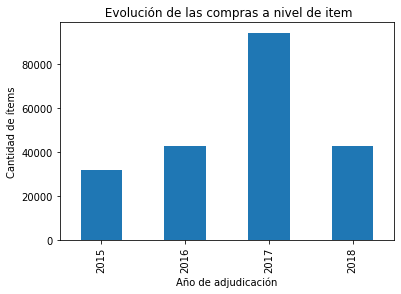

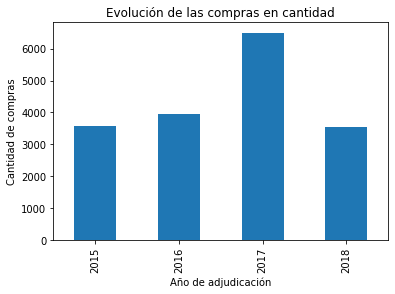

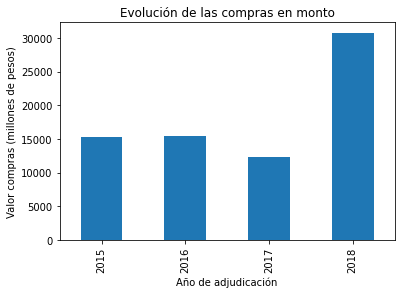

In [23]:
# Con el año se puede observar la evolución de las observaciones por año (a nivel de ítem)
data_inc['año'].value_counts(sort=False).plot(kind='bar', title=' Evolución de las compras a nivel de item', ylabel='Cantidad de ítems', xlabel='Año de adjudicación')
plt.savefig('Cantidad pde item.png')
plt.show()
data_inc.drop_duplicates(subset='id_compra')['año'].value_counts(sort=False).plot(kind='bar', title='Evolución de las compras en cantidad',ylabel='Cantidad de compras', xlabel='Año de adjudicación')
plt.savefig('Cantidad de compras.png')
plt.show()
data_inc.groupby('año')['val_tot'].sum().plot(kind='bar', title='Evolución de las compras en monto',ylabel='Valor compras (millones de pesos)', xlabel='Año de adjudicación')
plt.savefig('Montos de compras.png')
plt.show()


# Creación de la Red

Paquete utilizado NetwotkX

Para crear el grafo se considera que la Red funciona con la siguiente lógica: un proveedor es adjudicado en una o varias compras de una UC. Por tanto, el grafo será dirigido contando con dos tipos de nodos: las UC y los proveedores. Al mismo tiempo, los arcos vincularán los proveedores a las UE, siendo la importancia de cada uno (peso) dada por el monto total vendido a cada UC. Además como el grafo es dinámico, se agrega el año como un atributo de los vértices.

Al igual que en el trabajo de Chile se trabaja siempre con un grafo no dirigido.

In [31]:
# DataFrame con las aristas y sus atributos (peso y año).
edges_inc=pd.DataFrame(data_inc.groupby(['id_proveedor','id_inc_ue','año'])['val_tot'].agg(weight='sum').dropna())
edges_inc=edges_inc[edges_inc['weight']>0].reset_index()

In [32]:
edges_inc.columns

Index(['id_proveedor', 'id_inc_ue', 'año', 'weight'], dtype='object')

In [33]:
# Se crea el grafo con Networkx
g_buy = nx.Graph() # No dirigido
g_buy.add_nodes_from(edges_inc['id_inc_ue'], bipartite ='UC')
g_buy.add_nodes_from(edges_inc['id_proveedor'], bipartite = 'Proveedor')
g_buy.add_weighted_edges_from(
   [(row['id_proveedor'], row['id_inc_ue'], row['weight']) for i, row in edges_inc.iterrows()])

a=dict()
for i, row in edges_inc.iterrows():
  a[(row['id_proveedor'], row['id_inc_ue'])]=row['año']

nx.set_edge_attributes(g_buy,values=a, name='año') # Se agrega el atributo del año a las aristas



In [34]:
# Se crean dos set con los nodos de cada tipo, necesarios para aplicar estadísticas con el paquete Networkx
Proveedor_nodes = {n for n, d in g_buy.nodes(data=True) if d["bipartite"] == 'Proveedor'}
UC_nodes = set(g_buy) - Proveedor_nodes

In [35]:
print('El grafo tiene pesos en sus aristas?', nx.is_weighted(g_buy))
print('El grafo es bipartito? ', nx.is_bipartite(g_buy))
print('')
print('Cantidad de nodos: ', g_buy.number_of_nodes())
print(g_buy.nodes.data())
print('')
print('Cantidad de nodos del tipo Proveedor: ', len(Proveedor_nodes))
print('Cantidad de nodos del tipo UC: ', len(UC_nodes))
print('')
print('Cantidad de aristas ', g_buy.number_of_edges())
print(g_buy.edges.data())

El grafo tiene pesos en sus aristas? True
El grafo es bipartito?  True

Cantidad de nodos:  4932
[('67-1', {'bipartite': 'UC'}), ('4-1', {'bipartite': 'UC'}), ('90-1', {'bipartite': 'UC'}), ('25-3', {'bipartite': 'UC'}), ('5-3', {'bipartite': 'UC'}), ('25-1', {'bipartite': 'UC'}), ('15-1', {'bipartite': 'UC'}), ('11-1', {'bipartite': 'UC'}), ('11-2', {'bipartite': 'UC'}), ('29-28', {'bipartite': 'UC'}), ('29-34', {'bipartite': 'UC'}), ('4-31', {'bipartite': 'UC'}), ('80-1', {'bipartite': 'UC'}), ('11-19', {'bipartite': 'UC'}), ('9-1', {'bipartite': 'UC'}), ('4-30', {'bipartite': 'UC'}), ('25-2', {'bipartite': 'UC'}), ('15-2', {'bipartite': 'UC'}), ('29-54', {'bipartite': 'UC'}), ('11-24', {'bipartite': 'UC'}), ('16-101', {'bipartite': 'UC'}), ('11-3', {'bipartite': 'UC'}), ('12-106', {'bipartite': 'UC'}), ('7-4', {'bipartite': 'UC'}), ('10-3', {'bipartite': 'UC'}), ('29-15', {'bipartite': 'UC'}), ('29-68', {'bipartite': 'UC'}), ('3-18', {'bipartite': 'UC'}), ('3-23', {'bipartite': 'UC'

In [ ]:
#nx.draw(g_buy,pos=nx.drawing.layout.bipartite_layout(g_buy,Proveedor_nodes))

In [ ]:
#pos = dict()
#pos.update( (n, (1, i)) for i, n in enumerate(Proveedor_nodes) ) 
#pos.update( (n, (2, i)) for i, n in enumerate(UC_nodes) ) 

#plt.figure(figsize=(20,40))
#nx.draw_networkx(g_buy, pos=pos)
#plt.axis('off')
#plt.show()

# Análisis de la Red

En esta sección se presentan algunas estadísticas resumen para caracterizar el grafo.

## Conectividad del grafo
Se estudia si el grafo es conexo.

In [36]:
print(nx.is_connected(g_buy))

False


Cuántos componentes tiene? Los componentes conectados son un conjunto de nodos relacionados entre sí por alguna ruta en el subgrafo, pero no conectados con otros nodos en el global.

In [37]:
print('El grafo tiene ',nx.number_connected_components(g_buy), ' componentes')
print('')
i=1
clusters=dict()

for c in list(nx.connected_components(g_buy)):
  print('El componente',i,'esta compuesto por',len(c),'nodos')
  names=list()

  for n in c:
    names.append(n)
  
  print(names)
  clusters['key']=i
  clusters[i]=names
  i+=1

El grafo tiene  3  componentes

El componente 1 esta compuesto por 4923 nodos
['R216313140013', 'R210921070012', 'R215483080013', 'R213832200012', 'R160116250011', 'R215775370011', 'R212749580018', 'R212153220011', 'R210138720010', 'R213068290017', 'R213416610018', 'R215177360012', 'R211917010017', 'R212489650011', 'R214077890011', 'R210260470015', 'R130172690011', 'R215001510011', 'R215067420010', 'R200184030016', 'R216408530013', '29-63', 'R213762030016', 'R215758150017', 'R211882790011', 'R216651390019', 'R215230640010', 'R213740900018', 'T26006', '26-12', 'R217335520011', 'T08001', 'R214763120017', 'R213335530014', 'R216168700017', 'R210209260017', 'R216887620018', 'R215077160011', 'R040209590016', 'R214678490018', 'R216837600013', 'R213640750014', 'R211493240010', 'XBRA87.209.2500001-14', 'R213474880014', '29-7', 'R160174910010', 'R180253550011', 'R212517310011', 'R213649450013', 'R212668160019', 'R212344450011', 'R216072930011', 'R213797070014', 'R215471870014', 'R060034990015', 

In [50]:
print('Componente 2: Información de los nodos')
print('')
display(pd.DataFrame(data_inc[data_inc['id_inc_ue']==clusters[2][0]]).groupby(['id_proveedor','nombre_inc','nombre_ue','año'], observed=True)['val_tot'].sum())
print('')
print('Componente 3: Información de los nodos')
print('')
display(pd.DataFrame(data_inc[data_inc['id_inc_ue']==clusters[3][5]]).groupby(['id_proveedor','nombre_inc','nombre_ue','año'], observed=True)['val_tot'].sum())

Componente 2: Información de los nodos



id_proveedor   nombre_inc                                       nombre_ue                              año 
R130066990015  Administración de Servicios de Salud del Estado  Red de Atención Primaria de Río Negro  2018    0.980
R130090820019  Administración de Servicios de Salud del Estado  Red de Atención Primaria de Río Negro  2018    0.622
Name: val_tot, dtype: float64


Componente 3: Información de los nodos



id_proveedor   nombre_inc                     nombre_ue                              año 
R200078780015  Intendencia de Treinta y Tres  Junta Departamental de Treinta y Tres  2018    0.01600
R200095280017  Intendencia de Treinta y Tres  Junta Departamental de Treinta y Tres  2017    0.00155
                                                                                     2018    1.95376
R200103660014  Intendencia de Treinta y Tres  Junta Departamental de Treinta y Tres  2018    0.00723
R200138410014  Intendencia de Treinta y Tres  Junta Departamental de Treinta y Tres  2018    0.04062
R200175900011  Intendencia de Treinta y Tres  Junta Departamental de Treinta y Tres  2018    6.84761
Name: val_tot, dtype: float64

## Medidas de centralidad
A continuación se realizan algunas medidas de centralidad para dimensionar la importancia de los distintos nodos e identificar posibles comportamientos en torno a la Red.

### 1) Distribución de grado



In [39]:
deg_prov,deg_uc=nx.bipartite.degrees(g_buy,UC_nodes, weight='weight') # Devuelve dos diccionarios con los grados de cada nodo en cada set.

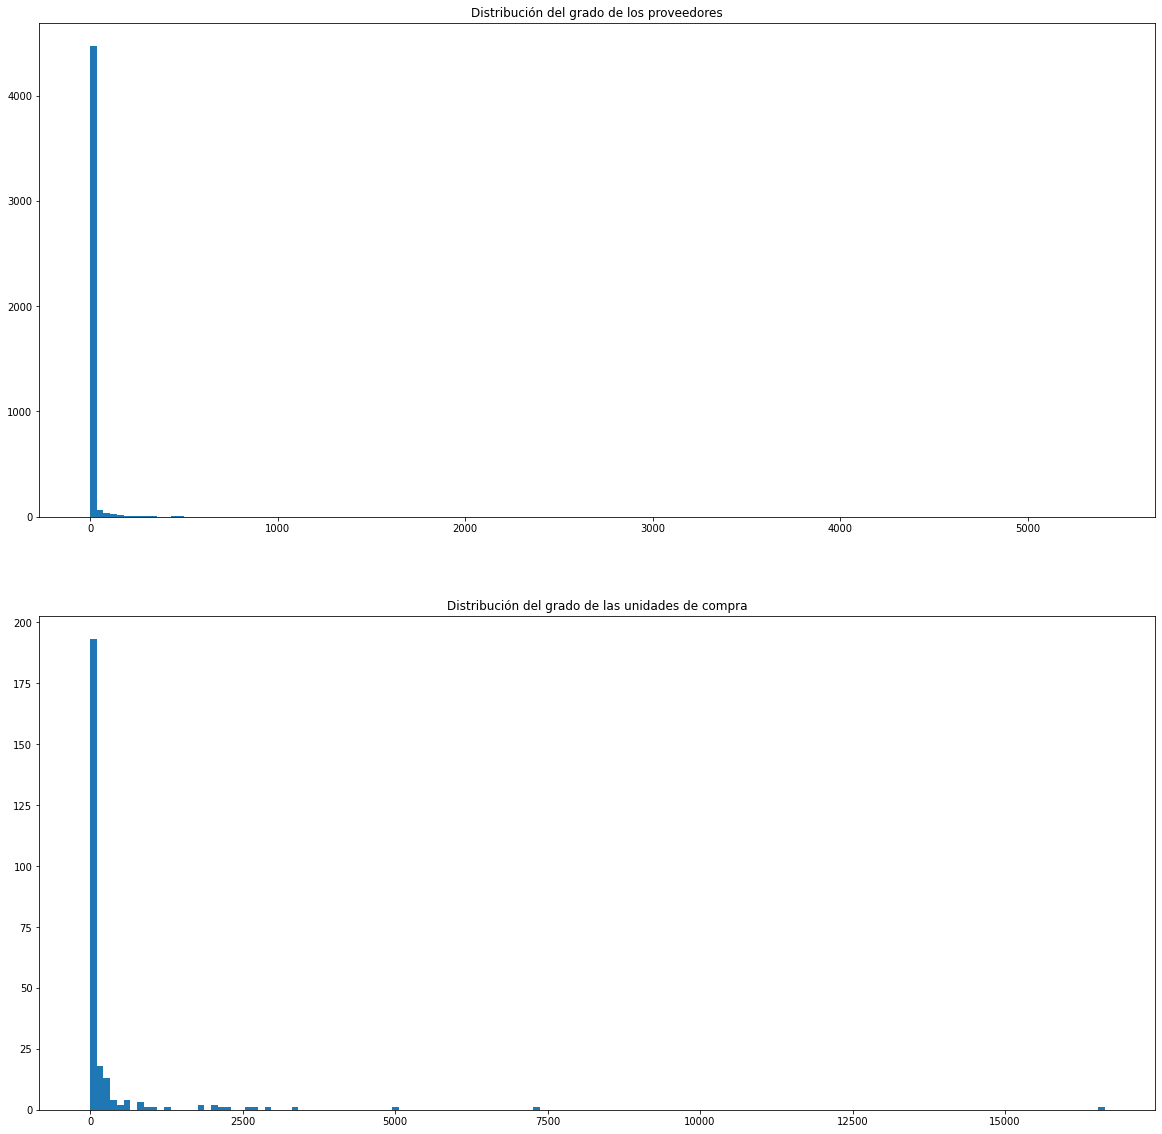

In [40]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20, 20))
ax1.hist(dict(deg_prov).values(),bins=151,density=False)
ax1.set_title('Distribución del grado de los proveedores')
ax2.hist(dict(deg_uc).values(),bins=151,density=False)
ax2.set_title('Distribución del grado de las unidades de compra')
plt.savefig('Distribucion_grados_1.png')
plt.show()


In [41]:
aux_4=[x for x in list(dict(deg_prov).values())]
aux_5=[x for x in list(dict(deg_uc).values())]

In [42]:
print('Cantidad de nodos de tipo proveedor por rango de grados')
print('')
display(pd.cut(np.array(aux_4),bins=[0,1,5,10,20,50,200,500,15000]).value_counts())
print('')
print('Cantidad de nodos de tipo UC por rango de grados')
print('')
display(pd.cut(np.array(aux_5),bins=[0,1,5,10,20,50,200,500,15000,20000]).value_counts())

Cantidad de nodos de tipo proveedor por rango de grados



(0, 1]          3328
(1, 5]           704
(5, 10]          181
(10, 20]         148
(20, 50]         140
(50, 200]        119
(200, 500]        35
(500, 15000]      24
dtype: int64


Cantidad de nodos de tipo UC por rango de grados



(0, 1]            44
(1, 5]            40
(5, 10]           27
(10, 20]          24
(20, 50]          27
(50, 200]         47
(200, 500]        21
(500, 15000]      22
(15000, 20000]     1
dtype: int64

Se observa que existen algunos nodos con valores atípicos en cuanto a su grado promedio, se procede a identificarlos.

In [43]:
aux_6=[x for x in list(dict(deg_prov).values()) if x>np.quantile(sorted(list(dict(deg_prov).values())),0.95)]
print('El 5% de los nodos de proveedores con grado ponderado mayor a ',round(np.quantile(sorted(list(dict(deg_prov).values())),0.95),4),' son ',len(aux_6), 'del total de ', len(deg_prov))
aux_7=[x for x in list(dict(deg_uc).values()) if x>np.quantile(sorted(list(dict(deg_uc).values())),0.95)]
print('El 5% de los nodos de UC con grado ponderado mayor a ',round(np.quantile(sorted(list(dict(deg_uc).values())),0.95),4),' son ',len(aux_7), 'del total de ', len(deg_uc))

El 5% de los nodos de proveedores con grado ponderado mayor a  31.1133  son  234 del total de  4679
El 5% de los nodos de UC con grado ponderado mayor a  1465.2294  son  13 del total de  253


In [44]:
aux_8=[(k,round(v)) for k,v in dict(deg_uc).items() if v in aux_7]
aux_8=pd.DataFrame(aux_8, columns=['UC','Grado Ponderado']).merge(UC,right_on='id_inc_ue',left_on='UC', how='left').drop('id_inc_ue',axis=1).sort_values('Grado Ponderado', ascending=False)
display(aux_8)

UC  Grado Ponderado  id_inc  \
7      9-3            16632       9   
6   16-101             7371      16   
3      6-1             5036       6   
5   12-103             3344      12   
11     3-4             2913       3   
8     3-33             2717       3   
9     25-2             2618      25   
4     61-1             2216      61   
12    27-1             2147      27   
0     64-1             2025      64   
2    29-18             1986      29   
1     83-1             1815      83   
10    84-1             1793      84   

                                           nombre_inc  id_ue  \
7                     Ministerio de Turismo y Deporte      3   
6                                      Poder Judicial    101   
3                 Ministerio de Relaciones Exteriores      1   
5                         Ministerio de Salud Pública    103   
11                     Ministerio de Defensa Nacional      4   
8                      Ministerio de Defensa Nacional     33   
9        Administración Nacional de Educación Pública      2   
4   Administración Nacional de Usinas y Trasmision...      1   
12       Instituto del Niño y Adolescente del Uruguay      1   
0                  Administración Nacional de Puertos      1   
2     Administración de Servicios de Salud del Estado     18   
1                              Intendencia de Colonia      1   
10                             Intendencia de Durazno      1   

                                            nombre_ue  
7                       Dirección Nacional de Turismo  
6                                      Poder Judicial  
3                 Ministerio de Relaciones Exteriores  
5                       Dirección General de la Salud  
11                       Comando General del Ejército  
8   Dirección Nacional de Sanidad de las Fuerzas A...  
9                       Consejo de Educación Primaria  
4   Administración Nacional de Usinas y Trasmision...  
12       Instituto del Niño y Adolescente del Uruguay  
0                  Administración Nacional de Puertos  
2    Centro Departamental de Salud Pública de Colonia  
1                    Intendencia Municipal de Colonia  
10                   Intendencia Municipal de Durazno

Como el grado no captura la correlación entre los grados (Fuente: https://mathinsight.org/degree_distribution#citation:1), se complementa con el cálculo del 'PageRank' considerando que este refleja la importancia de las UC en función a la cantidad de empresas que la proveen (cuán diversificadas tienen las compras en términos de proveedores) y el poder de dichos proveedores (ventas a distintas UC ponderadas por el peso).


In [45]:
PageRank=nx.pagerank(g_buy)
PR_top=sorted(PageRank.values(),reverse=True)[0:10]

In [46]:
aux_9=[(k,round(v,4)) for k,v in dict(PageRank).items() if v in PR_top]
aux_9=pd.DataFrame(aux_9, columns=['UC','PageRank']).merge(UC,right_on='id_inc_ue',left_on='UC', how='left').drop('id_inc_ue',axis=1).sort_values('PageRank', ascending=False)
display(aux_9)

UC  PageRank  id_inc                                    nombre_inc  \
4     3-4    0.0205       3                Ministerio de Defensa Nacional   
2  16-101    0.0165      16                                Poder Judicial   
8    3-33    0.0155       3                Ministerio de Defensa Nacional   
5    27-1    0.0130      27  Instituto del Niño y Adolescente del Uruguay   
6     9-3    0.0127       9               Ministerio de Turismo y Deporte   
1    25-2    0.0126      25  Administración Nacional de Educación Pública   
3    3-18    0.0123       3                Ministerio de Defensa Nacional   
7    98-1    0.0107      98                     Intendencia de Montevideo   
9    25-4    0.0100      25  Administración Nacional de Educación Pública   
0    15-1    0.0094      15               Ministerio de Desarrollo Social   

   id_ue                                          nombre_ue  
4      4                       Comando General del Ejército  
2    101                                     Poder Judicial  
8     33  Dirección Nacional de Sanidad de las Fuerzas A...  
5      1       Instituto del Niño y Adolescente del Uruguay  
6      3                      Dirección Nacional de Turismo  
1      2                      Consejo de Educación Primaria  
3     18                       Comando General de la Armada  
7      1                Intendencia Municipal de Montevideo  
9      4           Consejo de Educación Técnico-Profesional  
0      1                 Ex-Adm. Gral- Dir. General Secret.

### 2) Distribución de intermediación

In [52]:
bw=nx.betweenness_centrality(g_buy)

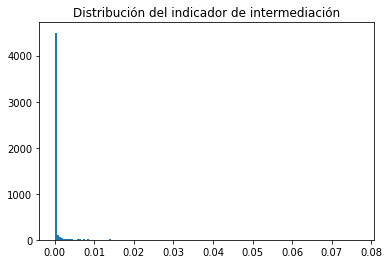

In [53]:
plt.figure()
plt.hist(bw.values(),bins=151)
plt.title('Distribución del indicador de intermediación')
plt.savefig('Distribucion_intermediacion_1.png')
plt.show()

In [54]:
aux_10=[x for x in list(dict(bw).values())]
print('Cantidad de nodos por rango de intermediación')
print('')
display(pd.cut(np.array(aux_10),bins=[0.00,0.005,0.01,0.03,0.10]).value_counts())

Cantidad de nodos por rango de intermediación



(0.0, 0.005]     2120
(0.005, 0.01]      55
(0.01, 0.03]       64
(0.03, 0.1]        13
dtype: int64

In [55]:
aux_10=[(k,round(v,3)) for k,v in dict(bw).items() if v>=0.03]
aux_10=pd.DataFrame(aux_10, columns=['nodo','intermediación']).merge(UC,right_on='id_inc_ue',left_on='nodo', how='left').drop('id_inc_ue',axis=1).sort_values('intermediación', ascending=False)
display(aux_10)

nodo  intermediación  id_inc  \
10           98-1           0.077    98.0   
6            3-18           0.060     3.0   
1             5-3           0.048     5.0   
4          16-101           0.047    16.0   
11           3-33           0.046     3.0   
12  R214854290012           0.041     NaN   
9           29-27           0.040    29.0   
7             3-4           0.038     3.0   
2            15-1           0.037    15.0   
3            25-2           0.036    25.0   
8            4-26           0.036     4.0   
0             4-1           0.034     4.0   
5            11-3           0.033    11.0   

                                         nombre_inc  id_ue  \
10                        Intendencia de Montevideo    1.0   
6                    Ministerio de Defensa Nacional   18.0   
1                 Ministerio de Economía y Finanzas    3.0   
4                                    Poder Judicial  101.0   
11                   Ministerio de Defensa Nacional   33.0   
12                                              NaN    NaN   
9   Administración de Servicios de Salud del Estado   27.0   
7                    Ministerio de Defensa Nacional    4.0   
2                   Ministerio de Desarrollo Social    1.0   
3      Administración Nacional de Educación Pública    2.0   
8                           Ministerio del Interior   26.0   
0                           Ministerio del Interior    1.0   
5                 Ministerio de Educación y Cultura    3.0   

                                            nombre_ue  
10                Intendencia Municipal de Montevideo  
6                        Comando General de la Armada  
1                      Auditoría Interna de la Nación  
4                                      Poder Judicial  
11  Dirección Nacional de Sanidad de las Fuerzas A...  
12                                                NaN  
9                       Centro Departamental de Rocha  
7                        Comando General del Ejército  
2                  Ex-Adm. Gral- Dir. General Secret.  
3                       Consejo de Educación Primaria  
8   Dir. Nac. Cárceles, Penitenciarías y Centros d...  
0              Secretaría del Ministerio del Interior  
5                       Dirección Nacional de Cultura

### 4) Cantidad de cliques de cada uno de los grafos

Por definición no existen cliques, ya que la relación siempre es de un proveedor a un comprador, no existe relación ni entre proveedores ni entre compradores.

Sin embargo, si no se considera la dirección de los vértices, los cliques serían todas las duplas de nodos que se relacionan a través de los mismos. En este caso existen cliques como vértices tiene el grafo.


In [56]:
print(list(nx.find_cliques(g_buy)))
len(list(nx.find_cliques(g_buy)))


[['R212796680015', '6-1'], ['R212796680015', '3-41'], ['R212796680015', '12-1'], ['R216313140013', '11-3'], ['R216313140013', '8-1'], ['R080112000019', '29-16'], ['R215310230013', '7-1'], ['R215913760014', '29-25'], ['R215913760014', '4-1'], ['R214116390010', '67-1'], ['R215128780011', '7-2'], ['R215128780011', '11-11'], ['R215128780011', '4-28'], ['R210921070012', '29-27'], ['R110073610015', '29-6'], ['R212949410019', '16-101'], ['R214640970012', '6-1'], ['R214640970012', '11-3'], ['R211081750011', '25-1'], ['R211081750011', '29-76'], ['R211081750011', '15-1'], ['R215483080013', '29-6'], ['R215483080013', '29-8'], ['R215483080013', '29-24'], ['R215483080013', '4-34'], ['R215483080013', '3-23'], ['R215483080013', '3-33'], ['R215483080013', '29-29'], ['R215483080013', '29-32'], ['R215483080013', '4-30'], ['R215483080013', '29-27'], ['R215483080013', '29-50'], ['R215483080013', '29-41'], ['R215483080013', '67-1'], ['R215483080013', '29-20'], ['R215483080013', '29-64'], ['R215483080013', 

21258

# Reducción del Grafo
En función a los resultados del análisis de las características del grafo, se decide reducir el mismo eliminando los nodos de tipo 'Proveedor' cuyo grado ponderado es menor a 1.


In [57]:
# Se identifican los nodos con grado ponderado menor a 1 y se eliminan
dict_grad_prov={} # diccionario con el proveedor y su grado promedio

for k,v in dict(deg_prov).items():
  if v<1:
    dict_grad_prov[k]=v

dict_grad_uc={} # diccionario con la uc y su grado promedio

for k,v in dict(deg_uc).items():
  if v<1:
    dict_grad_uc[k]=v

In [58]:
print('Los nodos de tipo proveedor con grado ponderado menor a 1 significan el', round(len(dict_grad_prov.keys())/len(Proveedor_nodes)*100,2),'%')
print('Los nodos de tipo UC con grado ponderado menor a 1 significan el', round(len(dict_grad_uc.keys())/len(UC_nodes)*100,2),'%')

Los nodos de tipo proveedor con grado ponderado menor a 1 significan el 71.13 %
Los nodos de tipo UC con grado ponderado menor a 1 significan el 17.39 %


In [59]:
g_buy.remove_nodes_from(list(dict_grad_prov))
g_buy.remove_nodes_from(list(dict_grad_uc))

In [60]:
Proveedor_nodes = {n for n, d in g_buy.nodes(data=True) if d["bipartite"] == 'Proveedor'}
UC_nodes = set(g_buy) - Proveedor_nodes

In [61]:
print('Cantidad total de nodos es', g_buy.number_of_nodes(), 'de los cuales ', len(Proveedor_nodes),' son de tipo Proveedor y ', len(UC_nodes),' son de tipo UC')
print(g_buy.nodes.data())

print('Cantidad de aristas ', g_buy.size())
print(g_buy.edges.data())

Cantidad total de nodos es 1560 de los cuales  1351  son de tipo Proveedor y  209  son de tipo UC
[('67-1', {'bipartite': 'UC'}), ('4-1', {'bipartite': 'UC'}), ('90-1', {'bipartite': 'UC'}), ('25-3', {'bipartite': 'UC'}), ('5-3', {'bipartite': 'UC'}), ('25-1', {'bipartite': 'UC'}), ('15-1', {'bipartite': 'UC'}), ('11-1', {'bipartite': 'UC'}), ('11-2', {'bipartite': 'UC'}), ('29-28', {'bipartite': 'UC'}), ('29-34', {'bipartite': 'UC'}), ('4-31', {'bipartite': 'UC'}), ('80-1', {'bipartite': 'UC'}), ('11-19', {'bipartite': 'UC'}), ('9-1', {'bipartite': 'UC'}), ('4-30', {'bipartite': 'UC'}), ('25-2', {'bipartite': 'UC'}), ('15-2', {'bipartite': 'UC'}), ('29-54', {'bipartite': 'UC'}), ('11-24', {'bipartite': 'UC'}), ('16-101', {'bipartite': 'UC'}), ('11-3', {'bipartite': 'UC'}), ('12-106', {'bipartite': 'UC'}), ('7-4', {'bipartite': 'UC'}), ('10-3', {'bipartite': 'UC'}), ('29-68', {'bipartite': 'UC'}), ('3-18', {'bipartite': 'UC'}), ('3-23', {'bipartite': 'UC'}), ('3-4', {'bipartite': 'UC'}

In [63]:
nx.write_graphml(g_buy,'Grafo_bipartito_redu.graphml')

# Proyección de la Red a 1D

Siguiendo el trabajo de Chile, se realiza la proyección del grafo bipartito a uno de una dimensión donde se vinculen solamente los proveedores en función de si son adjudicados a compras realizadas por la misma UC.

Dado que se quiere mantener el atributo del año en la proyección, la forma que se encontró de identificar las aristas por el año es mediante el siguiente procedimiento:
* 1) Se proyecta un subgrafo por año
* 2) Se agrega el atributo del año a cada vértices de cada subgrafo proyectado según corresponda.
* 3) Se unen todos los subgrafos 

De lo anterior se obtienen dos productos que luego serán utilizados para la detección de comunidades. Por un lado, cada subgrafo anual y, por otro, el grafo compilado. 

In [64]:
# Listas con las aristas de cada año
E2015 = [(u, v) for u,v,e in g_buy.edges.data() if e['año'] == 2015]
E2016 = [(u, v) for u,v,e in g_buy.edges.data() if e['año'] == 2016]
E2017 = [(u, v) for u,v,e in g_buy.edges.data() if e['año'] == 2017]
E2018 = [(u, v) for u,v,e in g_buy.edges.data() if e['año'] == 2018]

# Subgrafos con las aristas de cada año
g_buy_2015=g_buy.edge_subgraph(E2015).copy()
g_buy_2016=g_buy.edge_subgraph(E2016).copy()
g_buy_2017=g_buy.edge_subgraph(E2017).copy()
g_buy_2018=g_buy.edge_subgraph(E2018).copy()

# Sets con los nodos de cada año
Proveedor_nodes_2015 = {n for n, d in g_buy_2015.nodes(data=True) if d["bipartite"] == 'Proveedor'}
UC_nodes_2015 = set(g_buy_2015) - Proveedor_nodes_2015
Proveedor_nodes_2016 = {n for n, d in g_buy_2016.nodes(data=True) if d["bipartite"] == 'Proveedor'}
UC_nodes_2016 = set(g_buy_2016) - Proveedor_nodes_2016
Proveedor_nodes_2017 = {n for n, d in g_buy_2017.nodes(data=True) if d["bipartite"] == 'Proveedor'}
UC_nodes_2017 = set(g_buy_2017) - Proveedor_nodes_2017
Proveedor_nodes_2018 = {n for n, d in g_buy_2018.nodes(data=True) if d["bipartite"] == 'Proveedor'}
UC_nodes_2018 = set(g_buy_2018) - Proveedor_nodes

# Proyección de cada subgrafo a 1D
G2015 = bipartite.weighted_projected_graph(g_buy_2015, Proveedor_nodes_2015,ratio=True)
G2016 = bipartite.weighted_projected_graph(g_buy_2016, Proveedor_nodes_2016,ratio=True)
G2017 = bipartite.weighted_projected_graph(g_buy_2017, Proveedor_nodes_2017,ratio=True)
G2018 = bipartite.weighted_projected_graph(g_buy_2018, Proveedor_nodes_2018,ratio=True)

# Se agrega el atributo del año a cada arista
nx.set_edge_attributes(G2015,values=2015,name='año')
nx.set_edge_attributes(G2016,values=2016,name='año')
nx.set_edge_attributes(G2017,values=2017,name='año')
nx.set_edge_attributes(G2018,values=2018,name='año')

# Unión de los grafos proyectados 
#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.operators.all.compose_all.html#networkx.algorithms.operators.all.compose_all

G_list=[G2015,G2016,G2017,G2018]

G=nx.compose_all(G_list)


In [65]:
dict_proy={'Año':['2015','2016','2017','2018','Total'], 'Nodos de tipo Proveedor':[len(Proveedor_nodes_2015),len(Proveedor_nodes_2016),len(Proveedor_nodes_2017),len(Proveedor_nodes_2018),len(Proveedor_nodes)],'Nodos de tipo UC':[len(UC_nodes_2015),len(UC_nodes_2016),len(UC_nodes_2017),len(UC_nodes_2018),len(UC_nodes)],'Nodos total proyeccion':[G2015.number_of_nodes(),G2016.number_of_nodes(),G2017.number_of_nodes(),G2018.number_of_nodes(),G.number_of_nodes()],'Aristas proyeccion':[G2015.number_of_edges(),G2016.number_of_edges(),G2017.number_of_edges(),G2018.number_of_edges(),G.number_of_edges()]}
df_aux=pd.DataFrame(dict_proy)
display(df_aux)

Año  Nodos de tipo Proveedor  Nodos de tipo UC  Nodos total proyeccion  \
0   2015                      713                17                     713   
1   2016                      774                47                     774   
2   2017                      923                88                     923   
3   2018                      831                75                     831   
4  Total                     1351               209                    1351   

   Aristas proyeccion  
0               95480  
1              106169  
2              130974  
3               79781  
4              232949

La cantidad total de nodos del grafo proyectado compilado es 1351 que corresponde a la cantidad de nodos de tipo de proveedor de la red original. La diferencia en la suma de nodos de cada grafo proyectado anual y el compilado se debe a que los proveedores varían anualmente, por lo que algunos se repiten entre años mientras que otros ingresan o salen del mercado.

In [66]:
nx.write_graphml(G,'Grafo_proy_tot.graphml')
nx.write_graphml(G2015,'Grafo_proy_2015.graphml')
nx.write_graphml(G2016,'Grafo_proy_2016.graphml')
nx.write_graphml(G2017,'Grafo_proy_2017.graphml')
nx.write_graphml(G2018,'Grafo_proy_2018.graphml')

# Clasificación de vértices

En un principio se detectan las comunidades en el total del período utilizando tres métodos distintos de detección de comunidades, con el objetivo de seleccionar aquél que genera la mejor partición considerando tres indicadores distintos.

Del ejercicio anterior se obtiene el método de detección de comunidades que genera una mejor partición para el período en su totalidad. Como el objetivo del trabajo es observar cómo se comportan las comunidades a lo largo del período, a continuación se detectan las comunidades en cada año por separado, utilizando el método seleccionado en la etapa anterior.

Por último, se analiza e intenta caracterizar la evolución de las comunidades en el período para poder llegar a una conclusión sobre la existencia de sesgos.

## Detección de Comunidades

Se utiliza el mismo paquete NetworkX

In [70]:
!pip install community
import community
from community import community_louvain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
seed=47

In [72]:
# Algoritmo para detectar cual es la mejor particion max modularity con Louvain https://programmerclick.com/article/1051913693/

#first compute the best partition
partition = community_louvain.best_partition(G,random_state=seed) # Compute the partition of the graph nodes which maximises the modularity (or try…) using the Louvain heuristics. The result is a dict with the community numbered from 0 to the number of communities.


In [73]:
print('La cantidad de comunidades identificadas con el método Louvain son:',len(set(partition.values())))

La cantidad de comunidades identificadas con el método Louvain son: 8


In [74]:
dict_com_1={}

for key, value in partition.items():
  dict_com_1.setdefault(value, set()).add(key)

print(dict_com_1)

list_com_1=[] # Expreso las comunidades en una lista para utilizarla al medir los indicadores de calidad de la particion
for key, value in dict_com_1.items():
  list_com_1.append(list(value)) 

cant={}
for key, value in dict_com_1.items():
  #print(key, len([item for item in value if item]))
  cant[key]=len([item for item in value if item])

print(sorted(cant.items())) # diccionario con el tamaño de cada communidad 

{0: {'R212053400018', 'R213644680010', 'R210178580015', 'R212013430013', 'R213633320018', 'R210936400013', 'R212935800014', 'R215754000010', 'R216713660014', 'R210439700019', 'R210849440017', 'R213821850010', 'R020232140019', 'R214997520011', 'R212132540017', 'R210767220013', 'R215256920010', 'R213220280015', 'R210223730017', 'R210556280016', 'R214989330012', 'R210153680016', 'R212313490011', 'R110159870015', 'R211057180014', 'R214510330013', 'R080086190014', 'R210134110013', 'R100010490015', 'R210156480018', 'R212671470015', 'R210148400019', 'R215156000017', 'R211784920018', 'R211960810011', 'R213224550017', 'R213681940012', 'R216478370015', 'R215250410010', 'R210201320010', 'R212571460018', 'R214605770010', 'XARG33520719739', 'R214815250013', 'R210134210018', 'R217552350017', 'R214114060013', 'R213206330019', 'R214092850017', 'R020000560019', 'R212319050013', 'R211045340011', 'R210122040015', 'R216408530013', 'R210145460010', 'R211101590014', 'R212393200015', 'R212541380016', 'R21151

In [75]:
# This function uses Clauset-Newman-Moore greedy modularity maximization (agglomerative)

from networkx.algorithms.community import greedy_modularity_communities

random.seed(seed) 
np.random.seed(seed)
c = list(greedy_modularity_communities(G))
#sorted(c)


In [76]:
dict_com_2={}
for i,v in enumerate(c):
  #print(set(v))
  dict_com_2[i]=set(v)



cant_dict_com_2={}
for key, value in dict_com_2.items():
  cant_dict_com_2[key]=len([item for item in value if item])

print('La cantidad de comunidades identificadas con Clauset-Newman-Moore greedy modularity maximization (agglomerative) son:',max(dict_com_2.keys()))
print('')
print(dict_com_2) # nodos que conforman cada comunidad
print('')
print(cant_dict_com_2) # diccionario con el tamaño de cada communidad 


La cantidad de comunidades identificadas con Clauset-Newman-Moore greedy modularity maximization (agglomerative) son: 4

{0: {'R212796680015', 'R212765250019', 'R212053400018', 'R216313140013', 'R212692420017', 'R215310230013', 'R211673780013', 'R160266740014', 'R212013430013', 'R212796510012', 'R212292340016', 'R210936400013', 'R210000400017', 'R210849440017', 'R214949810013', 'R211812080015', 'R160298420015', 'R214640970012', 'R211528710018', 'R215562810014', 'R070132480019', 'R200053220016', 'R213539660013', 'R050014200011', 'R213689400017', 'R217808820017', 'R216949950016', 'R210153680016', 'R214695610018', 'R212153220011', 'R210198060017', 'R100312820018', 'R216672990015', 'R217072840010', 'R210166270016', 'R213798640019', 'R215762320010', 'R213747030019', 'R211899090018', 'R213881550013', 'R150106330015', 'R216286720018', 'R212671470015', 'R210148400019', 'T04004', 'R211784920018', 'R213224550017', 'R213711900013', 'R210231300018', 'R215250410010', 'R211809270011', 'R212489650011

In [77]:
# Con medidas de centralidad girvan_newman (divisive / betweenness centrailities https://memgraph.com/blog/community_detection-algorithms_with_python_networkxaon)

from networkx.algorithms.community.centrality import girvan_newman

random.seed(seed) 
np.random.seed(seed)
communities = girvan_newman(G)
node_groups = []
for com in next(communities):
  node_groups.append(list(com))


In [78]:
dict_com_3={}
for i,v in enumerate(node_groups):
  #print(set(v))
  dict_com_3[i]=set(v)

list_com_3=[] # Expreso las comunidades en una lista para utilizarla al medir los indicadores de calidad de la particion
for key, value in dict_com_3.items():
  list_com_3.append(list(value)) 

cant_dict_com_3={}
for key, value in dict_com_3.items():
  cant_dict_com_3[key]=len([item for item in value if item])

print('La cantidad de comunidades identificadas con centralidad girvan_newman (divisive / betweenness centrailities) son:',max(dict_com_2.keys()))
print('')
print(dict_com_3) # nodos que conforman cada comunidad
print('')
print(cant_dict_com_3) # diccionario con el tamaño de cada communidad 

La cantidad de comunidades identificadas con centralidad girvan_newman (divisive / betweenness centrailities) son: 4

{0: {'R212796680015', 'R216313140013', 'R217228220014', 'R215310230013', 'R160266740014', 'R210260940011', 'R211812080015', 'R214640970012', 'R213039810016', 'R215483080013', 'R160116250011', 'R160267630018', 'R050014200011', 'R213689400017', 'R070136860010', 'R212153220011', 'R216403890011', 'T04004', 'R212489650011', 'R210260470015', 'R217018070016', 'R214765780014', 'T04012', 'R216408530013', 'R215078650012', 'R214837300013', 'R211958430010', 'R215902630017', 'R211272240018', 'R211717710015', 'R215066530017', 'R214787000011', 'R213537330016', 'R210222730013', 'R140014680012', 'R211654210010', 'R216637760017', 'R214255840015', 'T04013', 'XUSA880062109', 'R214678490018', 'R213640750014', 'R170237090012', 'R211493240010', 'R214281900011', 'R100004430014', 'R040448710012', 'R212765070010', 'R210116200014', 'R214864380014', 'R212517310011', 'R213649450013', 'R040284660018

In [79]:
cant_nod_com=[cant,cant_dict_com_2,cant_dict_com_3]
cant_nod_com=pd.DataFrame(cant_nod_com)
cant_nod_com['Metodo']=['Louvain','Clauset-Newman-Moore','Girvan_Newman']
cant_nod_com=cant_nod_com.set_index('Metodo').fillna(0)
cant_nod_com=cant_nod_com[[0,1,2,3,4,5,6]]
display(cant_nod_com)

0    1    2      3     4     5     6
Metodo                                                       
Louvain                163  463  299  192.0  93.0  76.0  63.0
Clauset-Newman-Moore   715  412  134   88.0   2.0   0.0   0.0
Girvan_Newman         1348    2    1    0.0   0.0   0.0   0.0

In [80]:
import networkx.algorithms.community as nx_comm
#The *coverage* of a partition is the ratio of the number of intra-community edges to the total number of edges in the graph.
#The *performance* of a partition is the number of intra-community edges plus inter-community non-edges divided by the total number of potential edges.

ind={'Metodo':['Louvain','CNM','GN'],'Coverage':[round(nx.community.partition_quality(G,list_com_1)[0],2),round(nx.community.partition_quality(G,c)[0],2),round(nx.community.partition_quality(G,list_com_3)[0],2)],'Performance':[round(nx.community.partition_quality(G,list_com_1)[1],2),round(nx.community.partition_quality(G,c)[1],2),round(nx.community.partition_quality(G,list_com_3)[1],2)],'Modularity':[round(nx_comm.modularity(G,list_com_1),2),round(nx_comm.modularity(G,c),2),round(nx_comm.modularity(G,list_com_3),2)]}
ind=pd.DataFrame(ind)
ind=ind.set_index('Metodo')
display(ind)

Coverage  Performance  Modularity
Metodo                                    
Louvain      0.32         0.70        0.16
CNM          0.53         0.63        0.11
GN           1.00         0.26        0.00

## Evolución de las comunidades 

En base a lo anterior se selecciona el Método Louvain como el que mejor permite detectar comunidades en función al indicador de modularidad y de performance. Ahora se utilizará este método para observar cómo se comportan las comunidades en el período.

In [81]:
#partition={}
#for i,(k,v) in enumerate(graphs.items()):
 # partition[k]= community_louvain.best_partition(v)
partition2015 = community_louvain.best_partition(G2015,random_state=seed)
partition2016 = community_louvain.best_partition(G2016,random_state=seed)
partition2017 = community_louvain.best_partition(G2017,random_state=seed)
partition2018 = community_louvain.best_partition(G2018,random_state=seed)

In [82]:
dict_com_2015={}

for key, value in partition2015.items():
  dict_com_2015.setdefault(value, set()).add(key)

list_com_2015=[] # Expreso las comunidades en una lista para utilizarla al medir los indicadores de calidad de la particion
for key, value in dict_com_2015.items():
  list_com_2015.append(list(value)) 

cant_2015={}
for key, value in dict_com_2015.items():
  #print(key, len([item for item in value if item]))
  cant_2015[key]=len([item for item in value if item])

dict_com_2016={}

for key, value in partition2016.items():
  dict_com_2016.setdefault(value, set()).add(key)

#print(dict_com_2016)

list_com_2016=[] # Expreso las comunidades en una lista para utilizarla al medir los indicadores de calidad de la particion
for key, value in dict_com_2016.items():
  list_com_2016.append(list(value)) 

cant_2016={}
for key, value in dict_com_2016.items():
  #print(key, len([item for item in value if item]))
  cant_2016[key]=len([item for item in value if item])

dict_com_2017={}

for key, value in partition2017.items():
  dict_com_2017.setdefault(value, set()).add(key)

#print(dict_com_2017)

list_com_2017=[] # Expreso las comunidades en una lista para utilizarla al medir los indicadores de calidad de la particion
for key, value in dict_com_2017.items():
  list_com_2017.append(list(value)) 

cant_2017={}
for key, value in dict_com_2017.items():
  #print(key, len([item for item in value if item]))
  cant_2017[key]=len([item for item in value if item])

dict_com_2018={}

for key, value in partition2018.items():
  dict_com_2018.setdefault(value, set()).add(key)

#print(dict_com_2018)

list_com_2018=[] # Expreso las comunidades en una lista para utilizarla al medir los indicadores de calidad de la particion
for key, value in dict_com_2018.items():
  list_com_2018.append(list(value)) 

cant_2018={}
for key, value in dict_com_2018.items():
  #print(key, len([item for item in value if item]))
  cant_2018[key]=len([item for item in value if item])

print('La cantidad de comunidades identificadas con el método Louvain son:')
print('')
print('2015:',len(set(partition2015.values())), cant_2015)
print('2016:',len(set(partition2016.values())), cant_2016)
print('2017:',len(set(partition2017.values())), cant_2017)
print('2018:',len(set(partition2018.values())), cant_2018)


La cantidad de comunidades identificadas con el método Louvain son:

2015: 6 {0: 159, 1: 198, 2: 185, 4: 132, 3: 17, 5: 22}
2016: 3 {0: 298, 1: 288, 2: 188}
2017: 4 {1: 317, 2: 307, 0: 207, 3: 92}
2018: 7 {0: 82, 1: 219, 2: 205, 3: 110, 4: 37, 5: 176, 6: 2}


## Análisis de las comunidades

En esta sección se estudian distintas características de los subgrafos anuales para identificar padrones en la evolución de las comunidades.

Primero se compara cada comunidad de cada año con el año posterior a ver si existe isomorfismo entre comunidades. Para ello se crea un subgrafo de cada comunidad y luego se itera entre ellas comparando una a una entre años.

In [83]:
subg_com_2015={}

for k, v in dict_com_2015.items():
  subg_com_2015[k]=G2015.subgraph(v)

subg_com_2016={}

for k, v in dict_com_2016.items():
  subg_com_2016[k]=G2016.subgraph(v)

subg_com_2017={}

for k, v in dict_com_2017.items():
  subg_com_2017[k]=G2017.subgraph(v)
  
subg_com_2018={}

for k, v in dict_com_2018.items():
  subg_com_2018[k]=G2018.subgraph(v)

In [84]:
print('Comparación de comunidades en función al isomorfismo')
print('Comunidades 2015 vs 2016')
for k,v in subg_com_2015.items():
  for key,value in subg_com_2016.items():
    print(k,key,nx.could_be_isomorphic(v,value))
print('')
print('Comunidades 2016 vs 2017')
for k,v in subg_com_2016.items():
  for key,value in subg_com_2017.items():
    print(k,key,nx.could_be_isomorphic(v,value))
print('')
print('Comunidades 2017 vs 2018')
for k,v in subg_com_2017.items():
  for key,value in subg_com_2018.items():
    print(k,key,nx.could_be_isomorphic(v,value))


Comparación de comunidades en función al isomorfismo
Comunidades 2015 vs 2016
0 0 False
0 1 False
0 2 False
1 0 False
1 1 False
1 2 False
2 0 False
2 1 False
2 2 False
4 0 False
4 1 False
4 2 False
3 0 False
3 1 False
3 2 False
5 0 False
5 1 False
5 2 False

Comunidades 2016 vs 2017
0 1 False
0 2 False
0 0 False
0 3 False
1 1 False
1 2 False
1 0 False
1 3 False
2 1 False
2 2 False
2 0 False
2 3 False

Comunidades 2017 vs 2018
1 0 False
1 1 False
1 2 False
1 3 False
1 4 False
1 5 False
1 6 False
2 0 False
2 1 False
2 2 False
2 3 False
2 4 False
2 5 False
2 6 False
0 0 False
0 1 False
0 2 False
0 3 False
0 4 False
0 5 False
0 6 False
3 0 False
3 1 False
3 2 False
3 3 False
3 4 False
3 5 False
3 6 False


No se encuentra ninguna relación isomorfica entre las comunidades.

A continuación se compara la Modularidad de cada año que permitirá observar si existe algún año donde la detección de comunidades sea significativamente mejor o peor.

In [85]:
import networkx.algorithms.community as nx_comm
print('Indicador de modularidad')
print('')
print('2015:', round(nx_comm.modularity(G2015,list_com_2015),2))
print('2016:',round(nx_comm.modularity(G2016,list_com_2016),2))
print('2017:',round(nx_comm.modularity(G2017,list_com_2017),2))
print('2018:',round(nx_comm.modularity(G2018,list_com_2018),2))

Indicador de modularidad

2015: 0.17
2016: 0.15
2017: 0.15
2018: 0.16


Se observa que durante todo el período se mantiene aproximadamente la misma modularidad

Luego se decide observar alguna medida de centralidad con respecto a cada comunidad para dimensionar la distribución de la importancia de los nodos. Aquellas comunidades que cuenten con una medida de centralidad mayor, se puede considerar que son las más relevantes ya que significa que dichos proveedores presentan gran interrelación. Si se traduce lo anterior al grafo bipartito indicaría que existe alguna UC que interactúa con muchos proveedores. Se selecciona el Grado promedio como medida de centralidad.

In [86]:
grado_2015={}

for k, v in dict_com_2015.items():
  grado_2015[k]=round(statistics.mean([G2015.degree(i) for i in v]),2)

grado_2016={}

for k, v in dict_com_2016.items():
  grado_2016[k]=round(statistics.mean([G2016.degree(i) for i in v]),2)

grado_2017={}

for k, v in dict_com_2017.items():
  grado_2017[k]=round(statistics.mean([G2017.degree(i) for i in v]),2)

grado_2018={}

for k, v in dict_com_2018.items():
  grado_2018[k]=round(statistics.mean([G2018.degree(i) for i in v]),2)

print('El grado promedio de cada comunidad es:')
print('2015:', grado_2015)
print('2016:',grado_2016)
print('2017:',grado_2017)
print('2018:',grado_2018)

El grado promedio de cada comunidad es:
2015: {0: 245.62, 1: 316.99, 2: 303.16, 4: 227.63, 3: 36.82, 5: 108.45}
2016: {0: 229.41, 1: 327.81, 2: 263.64}
2017: {1: 323.12, 2: 277.78, 0: 294.66, 3: 143.98}
2018: {0: 80.77, 1: 210.57, 2: 279.42, 3: 268.38, 4: 72.89, 5: 98.42, 6: 1}


En función a la distribución del grado promedio de los nodos se observa que en el año 2015 la comunidad con el grado promedio mayor fue la 1, en el 2016 la 1, en el 2017 la 1 y en el 2018 la 2.

A continuación se sustrae solamente estas comunidades y las comparo para detectar si los nodos involucrados son similares.

In [88]:
comparacion1516 = [item for item in list_com_2015[1] if item in list_com_2016[1]]
print('Las comunidades 4 del 2015 y 0 del 2016 coinciden en', len(comparacion1516),'nodos, los cuales son',comparacion1516)
comparacion1617 = [item for item in list_com_2016[1] if item in list_com_2017[1]]
print('Las comunidades 0 del 2016 y 2 del 2017 coinciden en', len(comparacion1617),'nodos, los cuales son',comparacion1617)
comparacion1718 = [item for item in list_com_2017[1] if item in list_com_2018[2]]
print('Las comunidades 2 del 2017 y 4 del 2018 coinciden en', len(comparacion1718),'nodos, los cuales son',comparacion1718)
print('')
comparacion151617 = [item for item in comparacion1516 if item in comparacion1617]
print('De las comunidades seleccionadas para los años 2015,2016,2017 existen', len(comparacion151617),'nodos en común, los cuales son',comparacion151617)

comparacion15161718 = [item for item in comparacion151617 if item in comparacion1718]
print('De las comunidades seleccionadas para todos los años existe', len(comparacion15161718),'nodo en común, los cuales son',comparacion15161718)


Las comunidades 4 del 2015 y 0 del 2016 coinciden en 40 nodos, los cuales son ['R210114130019', 'R080177630017', 'R212313490011', 'R215566660017', 'R214510330013', 'R212895130013', 'R211136560014', 'R211585460017', 'R212706290018', 'R215069730017', 'R210305870017', 'R210302220011', 'R216553600019', 'R210771420013', 'R214826230019', 'R211746860011', 'R212864080014', 'R212101600018', 'R216473560010', 'R212116660011', 'R214837580016', 'R216112080013', 'R210830220011', 'R215156470013', 'R210001520016', 'R210118730010', 'R212622200018', 'R211370260013', 'R213673710011', 'R214366770015', 'R212733660017', 'R213201010016', 'R216539910014', 'R213878040018', 'R211129980011', 'R212974400013', 'R216558290018', 'R213265440011', 'R214346030016', 'R210478750013']
Las comunidades 0 del 2016 y 2 del 2017 coinciden en 49 nodos, los cuales son ['R010111080018', 'R213633320018', 'R215068570016', 'R213148820012', 'R211541470017', 'R211505770014', 'R213220280015', 'R212313490011', 'R214510330013', 'R2126842

De lo anterior se obtiene que existen 1 nodos que, en el trascurso del período considerado, pertenece a las comunidades con mayor grado promedio. Esto puede indicar una concentración de las ventas en dicho proveedor y por tanto, una posible posición dominante.

In [89]:
pd.DataFrame(comparacion15161718, columns=['Nodos'])

Nodos
0  R216558290018

In [90]:
aux_10={}

for p in comparacion15161718:
  aux_10[p]=list(g_buy.neighbors(p))

cant_nei={}
for key, value in aux_10.items():
  cant_nei[key]=len([item for item in value if item])


In [91]:
#print(aux_10)
pd.DataFrame(cant_nei, index=['Cantidad de vecinos']).T

Cantidad de vecinos
R216558290018                   12

In [92]:
aux_11=data_inc[data_inc['id_proveedor'].isin(comparacion15161718)]
aux_11=pd.DataFrame(aux_11.groupby(['id_proveedor','nombre_inc','nombre_ue','año'], observed=True)['val_tot'].sum())
aux_11.to_excel('Siete_nodos.xlsx')

Por último, se calcula el peso relativo de cada comunidad en las ventas totales por año en función al grado total de cada una. Esto permitirá responder la segunda pregunta de investigación.

In [93]:
grado_tot_2015={}

for k, v in dict_com_2015.items():
  grado_tot_2015[k]=round(sum([G2015.degree(i) for i in v]),2)

grado_tot_2016={}

for k, v in dict_com_2016.items():
  grado_tot_2016[k]=round(sum([G2016.degree(i) for i in v]),2)

grado_tot_2017={}

for k, v in dict_com_2017.items():
  grado_tot_2017[k]=round(sum([G2017.degree(i) for i in v]),2)

grado_tot_2018={}

for k, v in dict_com_2018.items():
  grado_tot_2018[k]=round(sum([G2018.degree(i) for i in v]),2)

print('El grado de cada comunidad es:')
print('2015:', grado_tot_2015)
print('2016:',grado_tot_2016)
print('2017:',grado_tot_2017)
print('2018:',grado_tot_2018)

El grado de cada comunidad es:
2015: {0: 39053, 1: 62764, 2: 56084, 4: 30047, 3: 626, 5: 2386}
2016: {0: 68365, 1: 94408, 2: 49565}
2017: {1: 102428, 2: 85279, 0: 60995, 3: 13246}
2018: {0: 6623, 1: 46115, 2: 57281, 3: 29522, 4: 2697, 5: 17322, 6: 2}


In [94]:
porc_grad_2015={}

for k,v in grado_tot_2015.items():
  porc_grad_2015[k]=round(v/sum(grado_tot_2015.values())*100,)

porc_grad_2016={}

for k,v in grado_tot_2016.items():
  porc_grad_2016[k]=round(v/sum(grado_tot_2016.values())*100,)
                          
porc_grad_2017={}

for k,v in grado_tot_2017.items():
  porc_grad_2017[k]=round(v/sum(grado_tot_2017.values())*100,)

porc_grad_2018={}

for k,v in grado_tot_2018.items():
  porc_grad_2018[k]=round(v/sum(grado_tot_2018.values())*100,)
                          
print('Peso relativo de cada comunidad:')
print('2015:', porc_grad_2015)
print('2016:', porc_grad_2016)
print('2017:', porc_grad_2017)
print('2018:', porc_grad_2018)

Peso relativo de cada comunidad:
2015: {0: 20, 1: 33, 2: 29, 4: 16, 3: 0, 5: 1}
2016: {0: 32, 1: 44, 2: 23}
2017: {1: 39, 2: 33, 0: 23, 3: 5}
2018: {0: 4, 1: 29, 2: 36, 3: 19, 4: 2, 5: 11, 6: 0}


Se observa que la segunda hipótesis no se cumple, debido a que, en todos los años existen comunidades que alcanzan un peso relativo en las ventas/compras anuales mayor al 30%.

##Graficos de comunidades

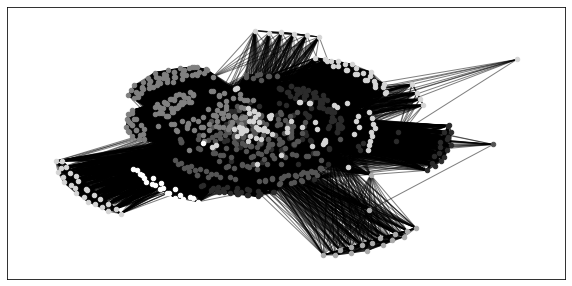

In [95]:
plt.figure(figsize=(10,5))
size = float(len(set(partition2015.values())))
pos = nx.spring_layout(G2015)
count = 0.
for com in set(partition2015.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition2015.keys()
                                if partition2015[nodes] == com]
    nx.draw_networkx_nodes(G2015, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

nx.draw_networkx_edges(G2015,pos, alpha=0.5)
plt.savefig('Comunidades_2015.png')
plt.show()

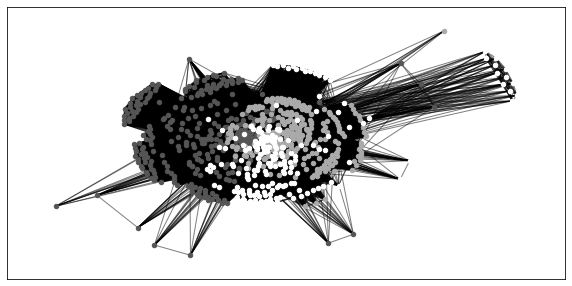

In [96]:
plt.figure(figsize=(10,5))
size = float(len(set(partition2016.values())))
pos = nx.spring_layout(G2016)
count = 0.
for com in set(partition2016.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition2016.keys()
                                if partition2016[nodes] == com]
    nx.draw_networkx_nodes(G2016, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

nx.draw_networkx_edges(G2016,pos, alpha=0.5)
plt.savefig('Comunidades_2016.png')
plt.show()

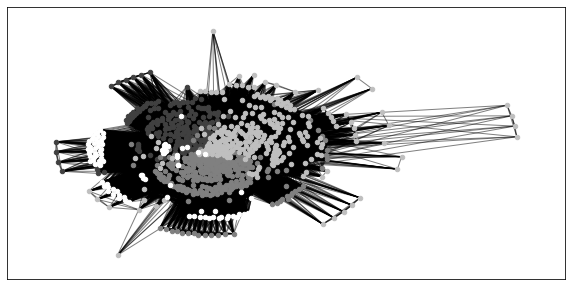

In [97]:
plt.figure(figsize=(10,5))
size = float(len(set(partition2017.values())))
pos = nx.spring_layout(G2017)
count = 0.
for com in set(partition2017.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition2017.keys()
                                if partition2017[nodes] == com]
    nx.draw_networkx_nodes(G2017, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

nx.draw_networkx_edges(G2017,pos, alpha=0.5)
plt.savefig('Comunidades_2017.png')
plt.show()

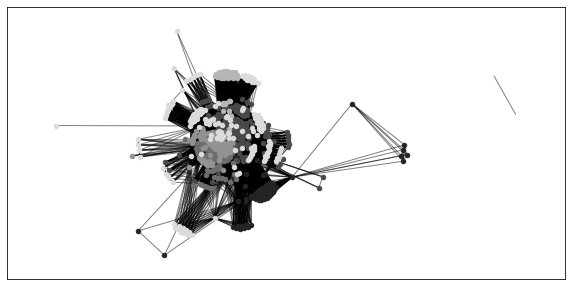

In [98]:
plt.figure(figsize=(10,5))
size = float(len(set(partition2018.values())))
pos = nx.spring_layout(G2018)
count = 0.
for com in set(partition2018.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition2018.keys()
                                if partition2018[nodes] == com]
    nx.draw_networkx_nodes(G2018, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

nx.draw_networkx_edges(G2018,pos, alpha=0.5)
plt.savefig('Comunidades_2018.png')
plt.show()